# Running CELLEX on MOCA dataset

# The data
The full version of Mouse Organogenesis Cell Atlas (MOCA) contains ~2 million cells, derived from 61 embryos staged between 9.5 and 13.5 days of gestation. Please see https://oncoscape.v3.sttrcancer.org/atlas.gs.washington.edu.mouse.rna/landing for more information. There are hundreds of cell types, 56 trajectories and thousands of corresponding marker genes. The dynamics of gene expression is defined within cell types and trajectories over time. 

For downstream analysis, the creators of the dataset (Cao, J. and Spielmann, M et al.) perfomed several rounds of cell filtering: (1) remove cells with less than 400 detected mRNA molecules, (2) remove all detected doublet cells, (3) remove all cells from doublet derived sub-clusters.

# Setup

Download the CELLEX repository:

In [1]:
# Install CELLEX to your env
#!pip install cellex

# Data preprocessing 
For testing and demonstration purposes, we choose the filtered MOCA dataset. It contains 100,000 unique cells sampled from the original MOCA dataset. Please download the RDS and cell annotations files with by the commands:

In [2]:
# macOS
# !curl -O https://shendure-web.gs.washington.edu/content/members/cao1025/public/mouse_embryo_atlas/cds_cleaned_sampled_100k.RDS 
# !curl -O https://shendure-web.gs.washington.edu/content/members/cao1025/public/mouse_embryo_atlas/cell_annotate.csv
    
# Linux
# !wget https://shendure-web.gs.washington.edu/content/members/cao1025/public/mouse_embryo_atlas/cds_cleaned_sampled_100k.RDS    
# !wget https://shendure-web.gs.washington.edu/content/members/cao1025/public/mouse_embryo_atlas/cell_annotate.csv

The RDS file contains 10 refined main trajectories (`Main_trajectory_refined_by_cluster`), obtained by splitting the cells during trajectory analysis, and 56 sub-trajectories (`Sub_trajectory_name`). `Main_Cluster` is the main cluster ID and `sub_cluster_id` is the sub-cluster ID after sub-clustering analysis.

A .loom file was generated via the following R script. A loom file can conveniently store the data and metadata needed by CELLEX.

```r
library(Seurat)
library(tidyverse)
library(here)
library(data.table)
library(RLinuxModules)
library(loomR)

### Read the data
cds <- readRDS(here("cds_cleaned_sampled_100k.RDS"))

### Get cds cell annotations 
### These annotations does not contain 
### all the information in cell_annotate.csv.gz (e.g. Sub_trajectory_Pseudotime is missing)
df.cell = Biobase::pData(cds) # cell meta-data | same as cds@phenoData@data
df.cell <- df.cell %>% select(sample) %>% as_tibble()

### Get annotations for all cells
df.annot <- data.table::fread(here("cell_annotate.csv"), nThread=50, showProgress=T) %>% as_tibble() 
glimpse(df.annot)

df.annot.sub <- df.annot %>% 
  filter(doublet_cluster==FALSE, detected_doublet==FALSE) %>% 
  select(sample, 
         celltype = Main_cell_type, 
         trajectory_main = Main_trajectory_refined_by_cluster, 
         celltype_subcluster_id = sub_cluster_id,
         trajectory_sub = Sub_trajectory_name, 
         pseudotime_trajectory_sub = Sub_trajectory_Pseudotime, 
         embryo_id,
         embryo_sex,
         development_stage) 

### Join
df.cell_w_annot <- df.cell %>% left_join(df.annot.sub, by="sample")

df.cell.seurat <- df.cell_w_annot %>% 
  mutate(cell_id = sample) %>% 
  select(cell_id, everything()) %>% 
  as.data.frame() %>% 
  column_to_rownames(var="sample")
gene_count = Biobase::exprs(cds)      # expression count matrix (unnormalized)

### Remove gene version number and check for duplicates when removing version number
gene_ids_without_version_number <- str_split(rownames(gene_count), pattern="\\.") %>% map_chr(1)
any(duplicated(gene_ids_without_version_number))    # --> FALSE
rownames(gene_count) <- gene_ids_without_version_number

### Create Seurat object
seurat_obj <- CreateSeuratObject(counts=gene_count, meta.data=df.cell.seurat)
seurat_obj@meta.data %>% as_tibble() %>% head()

df.annot %>% select(Main_Cluster, Sub_cluster, sub_cluster_id)
# Main_Cluster Sub_cluster sub_cluster_id
# <int>       <int> <chr>         
#   1            5          NA NA            
# 2           20           1 20-1          
# 3           21          NA NA            
# 4           17          NA NA            
# 5            6          NA NA            
# 6           25           1 25-1          
# 7           23          NA NA            
# 8            8          NA NA            
# 9            2          12 2-12          
# 10            6          28 6-28   
# ----> sub_cluster_id is SUFFICIENT to identify the main_cluster and sub_cluster
n_distinct(df.annot$sub_cluster_id) 
df.annot %>% filter(doublet_cluster==FALSE, detected_doublet==FALSE) %>% distinct(sub_cluster_id) %>% nrow() 

### Super important step!!! Tranforms seurat_obj$RNA@meta.features to a table. 
### We need seurat_obj$RNA@meta.features to have columns in order for the .loom file to be generated! 
seurat_obj <- FindVariableFeatures(object = seurat_obj)    

### Create the .loom file from the seurat object
pfile <- as.loom(x = seurat_obj, filename = "cds_cleaned_sampled_100k.loom", verbose = TRUE, overwrite = TRUE)

### Close the .loom file after all
pfile$close_all()
```

# Import packages

N.B. If you are missing any dependencies in your environment, your imports will fail until all dependencies are installed.

In [3]:
import loompy         # needed for importing data
import numpy as np    # needed for formatting data
import pandas as pd   # needed for formatting data
import cellex

# Set constants

In [4]:
### Set constants

dirOut = "cellex_moca_out"                    # output directory for results and plots
prefixData = "moca_100k"                      # prefix to prepend to files
pathData = "/scratch/lily/cds_cleaned_sampled_100k.loom"

nameAnno = "trajectory_main"                  # metadata annotation column attribute name
nameId = "CellID"                             # metadata cell id column attribute name
nameClass = "trajectory_main"                  # possible classes to group by: trajectory_main, trajectory_sub

# Import and format data

Cellex takes Pandas dataframes as input. These must conform to a certain format. See the output below.

## Data
If the dataset has duplicate cells, CELLEX is able to handle this. 

In [5]:
with loompy.connect(pathData) as ds:
    rows = (ds.row_attrs["Gene"])
    cols = (ds.col_attrs[nameId])
    #our data
    data = pd.DataFrame(ds[:, :], index=rows, columns=cols)
    # the type-annotation for individual cells
    metadata = pd.DataFrame(data={"cell_type" : ds.col_attrs[nameAnno]}, index=ds.col_attrs[nameId])
    metadata_class = pd.DataFrame(data={"cell_class" : ds.col_attrs[nameClass]}, index=ds.col_attrs[nameAnno])

In [6]:
data.head()

,sci3-me-001.ATTGAGGAATCGGAGATCCG,sci3-me-001.ACGAGGTTTAACTGATCTT,sci3-me-002.TCTTAGTTCTTATAGACGCA,sci3-me-002.TCCTAACTTTCCTTACTCCT,sci3-me-002.CAGTATCCTCCGCAAGTTC,sci3-me-002.CTAACGACTTTATAGCAGA,sci3-me-002.TGCTAATTCTGCTGGAACTT,sci3-me-002.ATTGATCGTTACGAAGTCAA,sci3-me-002.GAGACTAGTTTCTTCCGGT,sci3-me-002.TTCCATCTTTACGTCATATA,...,sci3-me-760.GCCATGGTTCGAATAATTC,sci3-me-760.GCTCTTAGTCATTCGACGG,sci3-me-760.GTAGCGATTGGCAATGAGA,sci3-me-760.CAACGCAGTCGCCGCCTCC,sci3-me-760.CCAGCCTTTTTGGACGCTG,sci3-me-760.TCAAGATCTTCAATTACCGT,sci3-me-760.GACCGAATTCATACTCCGA,sci3-me-760.ATTGATCGTTCGTAATGCAG,sci3-me-760.TTCTCATTGTATCGGCTATC,sci3-me-760.CTAGTACGTCGTAGTTACC
ENSMUSG00000051951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000103377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000104017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000103025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000089699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Metadata
Index values should be unique, like the cells. Alternatively, CELLEX will handle the duplicates.

In [7]:
metadata.head()

,cell_type
sci3-me-001.ATTGAGGAATCGGAGATCCG,Endothelial trajectory
sci3-me-001.ACGAGGTTTAACTGATCTT,Haematopoiesis trajectory
sci3-me-002.TCTTAGTTCTTATAGACGCA,Neural tube and notochord trajectory
sci3-me-002.TCCTAACTTTCCTTACTCCT,Mesenchymal trajectory
sci3-me-002.CAGTATCCTCCGCAAGTTC,Neural crest (PNS neuron) trajectory 3


Check how many cells are there in each <code>cell_type</code>:

In [8]:
print(metadata.groupby('cell_type').cell_type.count())

cell_type
Endothelial trajectory                     1857
Epithelial trajectory                      4978
Haematopoiesis trajectory                  3140
Hepatic trajectory                          834
Lens trajectory                              10
Mesenchymal trajectory                    44141
Neural crest (PNS glia) trajectory 2       1710
Neural crest (PNS neuron) trajectory 3     1910
Neural crest (melanocyte) trajectory 1      164
Neural tube and notochord trajectory      41256
Name: cell_type, dtype: int64


# Create `ESObject` and compute Expression Specificity

The <code>ESObject</code> is the fundamental class of the CELLEX package. It integrates the core features of CELLEX: computation of ES genes, generating plots and saving results to disk. We set <code>verbose=True</code> to get some progress reports.

In the following, we 

1) create the ESOject using the annotation from the metadata,

2) compute ESw, ESw* and ESmu

3) and inspect the results.

N.B. the computations may take a while depending on the data and available computational power.

In [9]:
eso = cellex.ESObject(data=data, annotation=metadata, verbose=True)

Preprocessing - checking input ... input parsed in 0 min 0 sec
Preprocessing - running remove_non_expressed ... excluded 28 / 26183 genes in 1 min 27 sec
Preprocessing - normalizing data ... data normalized in 6 min 7 sec
Preprocessing - running ANOVA ... excluded 12346 / 26155 genes in 4 min 50 sec


In [10]:
eso.compute(verbose=True)

Computing DET ... 
    esw ...
    empirical p-values ...
    esw_s ...
    finished in 0 min 19 sec
Computing EP ...
    esw ...
    empirical p-values ...
    esw_s ...
    finished in 0 min 0 sec
Computing GES ...
    esw ...
    empirical p-values ...
    esw_s ...
    finished in 2 min 1 sec
Computing NSI ...
    esw ...
    empirical p-values ...
    esw_s ...
    finished in 0 min 0 sec
Computing ESmu ...
    finished in 0 min 0 sec
Computing ESsd ...
    finished in 0 min 0 sec
Computed ['det.esw', 'det.esw_null', 'det.pvals', 'det.esw_s', 'ep.esw', 'ep.esw_null', 'ep.pvals', 'ep.esw_s', 'ges.esw', 'ges.esw_null', 'ges.pvals', 'ges.esw_s', 'nsi.esw', 'nsi.esw_null', 'nsi.pvals', 'nsi.esw_s', 'esmu', 'essd'].


In [11]:
eso.results["esmu"].head()

,Endothelial trajectory,Epithelial trajectory,Haematopoiesis trajectory,Hepatic trajectory,Lens trajectory,Mesenchymal trajectory,Neural crest (PNS glia) trajectory 2,Neural crest (PNS neuron) trajectory 3,Neural crest (melanocyte) trajectory 1,Neural tube and notochord trajectory
ENSMUSG00000051951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.589615,0.000000,0.554942
ENSMUSG00000103377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.673055,0.234674,0.179480
ENSMUSG00000104017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.695298,0.000000,0.456519
ENSMUSG00000103025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.700069,0.000000,0.390880
ENSMUSG00000089699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.426948,0.126812,0.195254


# (Optional) Map mouse Ensembl gene id's to human Ensembl gene id's

In [12]:
cellex.utils.mapping.ens_mouse_to_ens_human(eso.results["esmu"], drop_unmapped=True, verbose=True)
cellex.utils.mapping.ens_human_to_symbol(eso.results["esmu"], drop_unmapped=True, verbose=True)

cellex.utils.mapping.ens_mouse_to_ens_human(eso.results["essd"], drop_unmapped=True, verbose=True)
cellex.utils.mapping.ens_human_to_symbol(eso.results["essd"], drop_unmapped=True, verbose=True)

Mapping: mouse ensembl gene id's --> human ensembl gene id's ...
23.58 pct of genes are unmapped ...
Removed 3256 unmapped genes ...
Mapping: human ensembl gene id's --> gene names ...
0.61 pct of genes are unmapped ...
Removed 64 unmapped genes ...
Mapping: mouse ensembl gene id's --> human ensembl gene id's ...
23.58 pct of genes are unmapped ...
Removed 3256 unmapped genes ...
Mapping: human ensembl gene id's --> gene names ...
0.61 pct of genes are unmapped ...
Removed 64 unmapped genes ...


In [13]:
eso.results["esmu"].head()

,Endothelial trajectory,Epithelial trajectory,Haematopoiesis trajectory,Hepatic trajectory,Lens trajectory,Mesenchymal trajectory,Neural crest (PNS glia) trajectory 2,Neural crest (PNS neuron) trajectory 3,Neural crest (melanocyte) trajectory 1,Neural tube and notochord trajectory
XKR4,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.589615,0.0,0.554942
RP1,0.768983,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.123431
SOX17,0.989063,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
MRPL15,0.000000,0.018166,0.049267,0.277541,0.0,0.0,0.0,0.000000,0.0,0.000000
LYPLA1,0.189016,0.268122,0.000000,0.197348,0.0,0.0,0.0,0.148387,0.0,0.000000


# Save results to disk

By default, only ESmu is saved.

Function signature: <code>eso.save_as_csv(keys: list=None, path: str=None, file_prefix: str=None, verbose: bool=False)</code>

<code>keys</code>
<ul>
    <li>Using 'keys', the user may specify which results are saved.</li>
    <li>If keys is None, only ESmu is saved.</li>
    <li>If keys contains the keyword: "all", all results are saved.</li>
</ul>

<code>path</code>
<ul>
    <li>dir_name defaults to "out"</li>
    <li>To save in the current working directory, pass dir_name="."</li>
</ul>

<code>file_prefix</code>
<ul>
<li>Prefix is appended to the saved files. A dot is used to separate prefix from the result key.</li>
    </ul>

In [14]:
eso.save_as_csv(file_prefix=prefixData, path=dirOut, verbose=True)

Saving results as csv to disk ...
  Saved: cellex_moca_out/moca_100k.esmu.csv.gz
  Saved: cellex_moca_out/moca_100k.essd.csv.gz
Finished saving results to cellex_moca_out


# Plot results

CELLEX provides a handful of plotting features for quick visualization of results. Below we plot the top 5 ES genes for each cell-type.

In [15]:
df_esmu = eso.results["esmu"].copy()
es_max_genes = [(df_esmu.nlargest(n=5, columns=[col]).index.values) for col in df_esmu]
genes_to_plot = list(set(np.array(es_max_genes).flatten().tolist()))       # set() removes duplicates

In [16]:
df_esmu.loc[genes_to_plot].head()

,Endothelial trajectory,Epithelial trajectory,Haematopoiesis trajectory,Hepatic trajectory,Lens trajectory,Mesenchymal trajectory,Neural crest (PNS glia) trajectory 2,Neural crest (PNS neuron) trajectory 3,Neural crest (melanocyte) trajectory 1,Neural tube and notochord trajectory
RFX6,0.0,0.979412,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
GABRP,0.0,0.988678,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
FYB1,0.0,0.000000,0.98969,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
C8A,0.0,0.000000,0.00000,0.993127,0.0,0.000000,0.0,0.0,0.0,0.0
TACSTD2,0.0,0.985130,0.00000,0.000000,0.0,0.070848,0.0,0.0,0.0,0.0


# profile_gene plot

(There is a known bug with the labels. Sometimes they are shifted one place to the left or do not show).

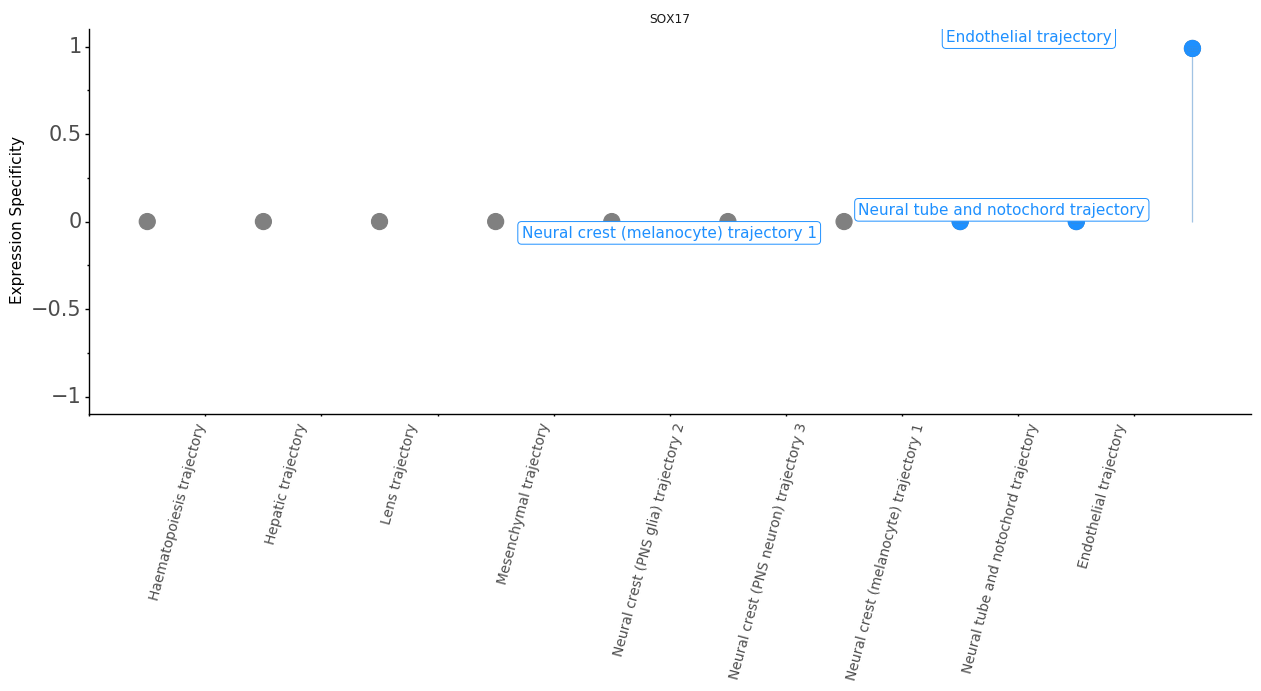

<ggplot: (-9223363278846852366)>

In [18]:
p_esmu = cellex.plotting.gene_profile(genes=["SOX17"], weights=eso.results["esmu"], 
                                      stddev=eso.results["essd"], highlight_n=3)
p_esmu

# `heatmap` plot
It is advisable to select a limited number of genes and annotations. Heatmaps generated for the full dataset are tough on the eyes!

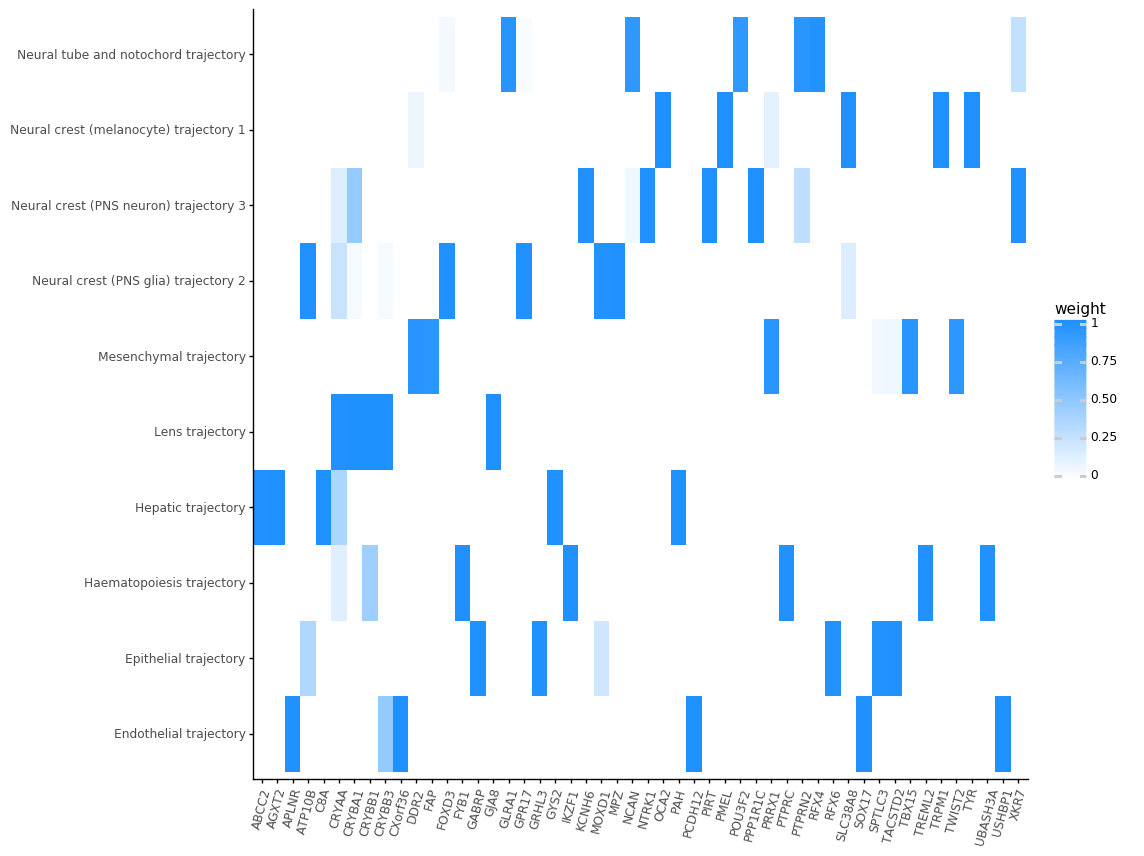

<ggplot: (8759313664737)>

In [19]:
p_heatmap = cellex.plotting.heatmap(df_esmu, genes=genes_to_plot)
p_heatmap

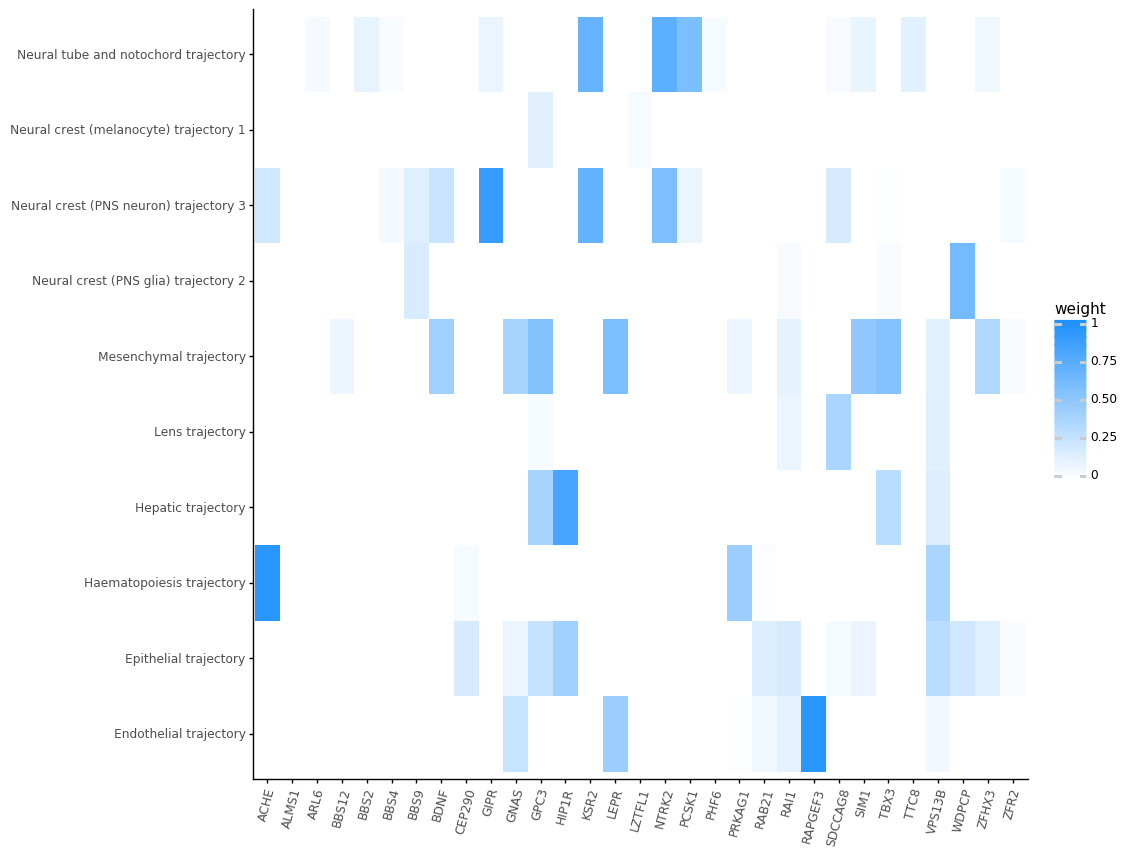

<ggplot: (-9223363277541102206)>

In [20]:
bmi_genes = ["ZFHX3", "BDNF", "CEP19", "KSR2", "ENTPD6", "ACHE", "ZFR2", "BBS4", "TRIM32", "PCSK1", "BBS12", "POMC", "WNT10B", "GPC3", "ARL6", "BBS9", "PRKAG1", "OFD1", "RAPGEF3", "TBX3", "MKS1", "LEP", "LEPR", "PHF6", "WDPCP", "BBS2", "BBS10", "RAB23", "MC4R", "HIP1R", "GIPR", "SIM1", "ALMS1", "ZNF169", "RAB21", "GNAS", "PRKAR1A", "BBS7", "RAI1", "SH2B1", "NTRK2", "CEP290", "MKKS", "LZTFL1", "VPS13B", "SDCCAG8", "TTC8"]
cellex.plotting.heatmap(df_esmu, genes=bmi_genes)

# Save plots to disk

In [24]:
fp = "{}/{}.esmu.heatmap.pdf".format(dirOut, prefixData)
cellex.plotting.save_as_pdf(p_heatmap, filename=fp, path=dirOut, dpi=600, verbose=True)

Saved: cellex_moca_out/moca_100k.esmu.heatmap.pdf


# Cleaning

In [ ]:
# delete ESObject when completed to release memory
del eso